In [ ]:
# @title # Import Everything
!git clone https://github.com/aaronkeyser/ECE_471_Keyser_Kline

import numpy as np
import pandas as pd
import kagglehub
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import layers, models,  Model
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.get_logger().setLevel('ERROR')


# Download latest version
path = kagglehub.dataset_download("fahadullaha/facial-emotion-recognition-dataset")

print("Path to dataset files:", path)

Cloning into 'ECE_471_Keyser_Kline'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10 (from 1)
Receiving objects: 100% (10/10), 2.27 MiB | 1.96 MiB/s, done.
Using Colab cache for faster access to the 'facial-emotion-recognition-dataset' dataset.
Path to dataset files: /kaggle/input/facial-emotion-recognition-dataset


Found 49779 files belonging to 7 classes.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


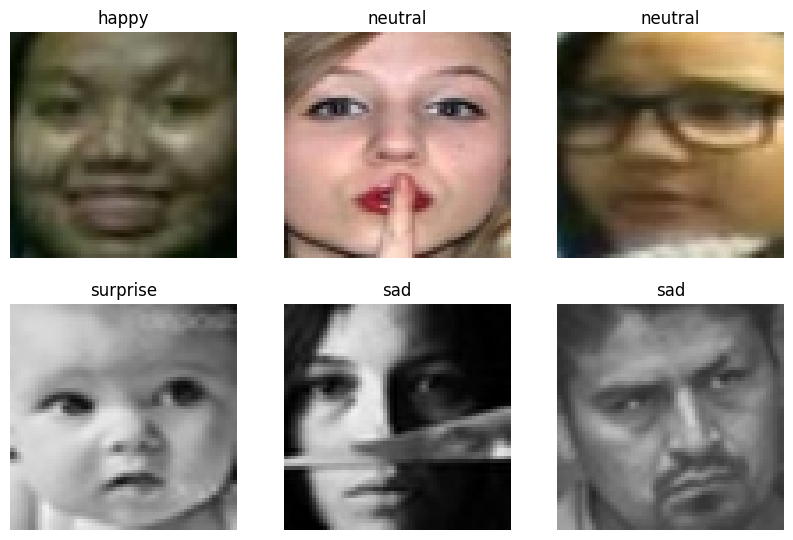

In [ ]:
# @title # Process Images and Load Examples
IMAGE_SIZE = 64
BATCH_SIZE = 32
DATASET_DIR = '/kaggle/input/facial-emotion-recognition-dataset/processed_data'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
n_classes = len(class_names)
print("Classes:", class_names)

import matplotlib.pyplot as plt

# Take one batch from the dataset
for images, labels in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

In [ ]:
# @title # Divide the Data Into Subsets

val_size = int(len(dataset) * 0.1)
test_size = int(len(dataset) * 0.1)
train_size = len(dataset) - val_size - test_size

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

print(f"Training batches: {len(train_ds)}")
print(f"Validation batches: {len(val_ds)}")
print(f"Test batches: {len(test_ds)}")

Training batches: 1246
Validation batches: 155
Test batches: 155


In [ ]:
# @title # Define Our Convolutional Blocks
def identity_block(x, filters):
    # Example for an identity block
    f1, f2, f3 = filters
    x_skip = x

    x = layers.Conv2D(f1, (1, 1), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(f2, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(f3, (1, 1), activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Add()([x, x_skip])
    x = layers.ReLU()(x)
    return x

def conv_block(x, filters, strides=(2, 2)):
    # Example for a convolutional block
    f1, f2, f3 = filters
    x_skip = x

    x = layers.Conv2D(f1, (1, 1), strides=strides, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(f2, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(f3, (1, 1), activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x_skip = layers.Conv2D(f3, (1, 1), strides=strides, activation='relu')(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)

    x = layers.Add()([x, x_skip])
    x = layers.ReLU()(x)
    return x

In [ ]:
# @title # Define the Function to Build Our Network
def build_resnet50(input_shape=(224, 224, 3), num_classes=1000):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((3, 3), strides=(2, 2), padding='same')(x)

    # Stage 2
    x = conv_block(x, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])

    # Stage 3
    x = conv_block(x, [128, 128, 512], strides=(2, 2))
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])

    # Stage 4
    x = conv_block(x, [256, 256, 1024], strides=(2, 2))
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])

    # Stage 5
    x = conv_block(x, [512, 512, 2048], strides=(2, 2))
    x = identity_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name='resnet50')
    return model

# Example usage:
model = build_resnet50(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=n_classes)
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     16,640 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 16, 16,    │          0 │ add[0][0]         │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │     16,448 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     36,928 │ batch_normalizat

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# @title # Compile and Train

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_ds, epochs=20)

Epoch 1/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 154s 83ms/step - accuracy: 0.2071 - loss: 2.6433
Epoch 2/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 67s 54ms/step - accuracy: 0.2945 - loss: 1.9913
Epoch 3/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 67s 54ms/step - accuracy: 0.3692 - loss: 1.6979
Epoch 4/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 67s 54ms/step - accuracy: 0.3886 - loss: 1.6477
Epoch 5/20
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step - accuracy: 0.4146 - loss: 1.6035
Epoch 6/20
  90/1246 ━━━━━━━━━━━━━━━━━━━━ 1:02 54ms/step - accuracy: 0.3819 - loss: 1.7389

In [ ]:
# @title # Evaluate Loss and Accuracy

loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

155/155 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.6196 - loss: 49.9814
Test Loss: 52.9068
Test Accuracy: 0.6099


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━

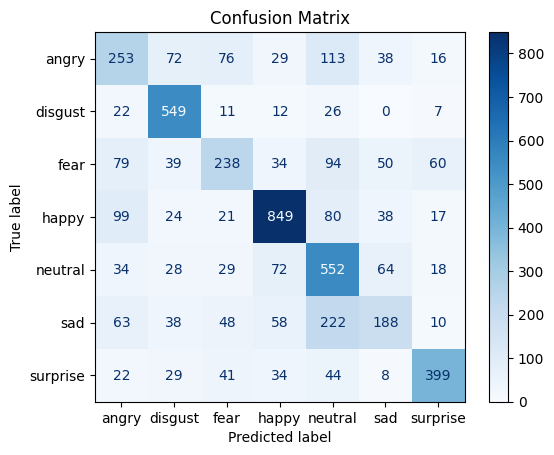

In [ ]:
# @title # Create Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np



all_labels = []
all_predictions = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    all_labels.extend(labels.numpy())
    all_predictions.extend(predicted_classes)

cm = confusion_matrix(all_labels, all_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# @title # Test With New Images

from google.colab import files
from IPython.display import Image as DisplayImage, display
from PIL import Image as PILImage
import io
import math

def preprocess_image(uploaded_file):
    """Preprocess uploaded image for our model"""
    # Read the uploaded file
    image = PILImage.open(io.BytesIO(uploaded_file)).convert('RGB')

    # Resize to our size (32x32)
    image = image.resize((32, 32))

    # Convert to numpy array and normalize
    image_array = np.array(image) / 255.0

    # Add batch dimension
    image_batch = np.expand_dims(image_array, axis=0)

    return image_batch, image

print("🎮 FUN ACTIVITY: Test with Multiple Images!")
print("=" * 60)
print("📸 CHALLENGE: Upload at least 3 different images!")
print("   Try images of different classes like:")
print("   - Airplane, car, bird, cat, dog, etc.")
print("   - Or anything else - be creative!")
print("   - The model was trained on 32x32 images")
print("\n💡 You can select multiple files at once when uploading!")
print("   Hold Ctrl (or Cmd on Mac) to select multiple images")

# Upload multiple files
print("\n⬆️  Ready to upload! Click 'Choose Files' below:")
uploaded = files.upload()

if uploaded:
    print(f"\n🎉 Successfully uploaded {len(uploaded)} images!")
    print("🔮 Making predictions for all images now...")

    # Create a figure to show all results - PROPER CALCULATION
    num_images = len(uploaded)
    rows = num_images  # One row per image
    cols = 2  # Two columns: original and resized

    fig = plt.figure(figsize=(15, 5 * rows))

    for i, filename in enumerate(uploaded.keys()):
        print(f"\n{'='*50}")
        print(f"📁 Image {i+1}: {filename}")

        # Preprocess the image
        processed_image, original_image = preprocess_image(uploaded[filename])

        # Make prediction
        prediction = model.predict(processed_image, verbose=0)
        predicted_class_index = np.argmax(prediction[0]) # Renamed predicted_class to predicted_class_index to avoid conflict
        confidence = prediction[0][predicted_class_index]

        # Plot the image and predictions - SIMPLE SUBPLOT INDEXING
        # Left column: Original image
        ax1 = plt.subplot(rows, cols, i * 2 + 1)
        plt.imshow(original_image)
        plt.title(f"Image {i+1}: {filename}\nTrue Size", fontsize=10)
        plt.axis('off')

        # Right column: Resized version
        ax2 = plt.subplot(rows, cols, i * 2 + 2)
        plt.imshow(processed_image[0])  # Show the 32x32 version
        plt.title(f"What Model Sees (32x32)\nPrediction: {class_names[predicted_class_index]}\nConfidence: {confidence:.2%}",
                 fontsize=10, color='green' if confidence > 0.5 else 'orange')
        plt.axis('off')



        print(f"🎯 Model prediction: {class_names[predicted_class_index]}")
        print(f"📊 Confidence: {confidence:.2%}")

        # Show top 3 predictions
        top_3_indices = np.argsort(prediction[0])[-3:][::-1]
        print("🏆 Top 3 predictions:")
        for j, idx in enumerate(top_3_indices):
            medal = "🥇" if j == 0 else "🥈" if j == 1 else "🥉"
            print(f"   {medal} {class_names[idx]}: {prediction[0][idx]:.3f}")

    plt.tight_layout()
    plt.show()

    predicted_class_name = class_names[predicted_class_index]
    if predicted_class_name == 'happy':
      display(DisplayImage("/content/ECE_471_Keyser_Kline/Monkeys/Happy_Monkey.jpg"))
    elif predicted_class_name == 'sad':
      display(DisplayImage("/content/ECE_471_Keyser_Kline/Monkeys/Sad_Monkey.jpg"))
    elif predicted_class_name == 'fear':
      display(DisplayImage("/content/ECE_471_Keyser_Kline/Monkeys/Scared_Monkey.jpg"))
    elif predicted_class_name == 'angry':
      display(DisplayImage("/content/ECE_471_Keyser_Kline/Monkeys/Angry_Monkey.jpg"))
    elif predicted_class_name == 'disgust':
      display(DisplayImage("/content/ECE_471_Keyser_Kline/Monkeys/Disgusted_Monkey.jpg"))
    elif predicted_class_name == 'surprise':
      display(DisplayImage("/content/ECE_471_Keyser_Kline/Monkeys/Surprised_Monkey.jpg"))
    else:
      display(DisplayImage("/content/ECE_471_Keyser_Kline/Monkeys/Neutral_Monkey.jpg"))


🎮 FUN ACTIVITY: Test with Multiple Images!
📸 CHALLENGE: Upload at least 3 different images!
   Try images of different classes like:
   - Airplane, car, bird, cat, dog, etc.
   - Or anything else - be creative!
   - The model was trained on 32x32 images

💡 You can select multiple files at once when uploading!
   Hold Ctrl (or Cmd on Mac) to select multiple images

⬆️  Ready to upload! Click 'Choose Files' below:


Saving Screenshot 2023-07-20 184034.png to Screenshot 2023-07-20 184034 (2).png

🎉 Successfully uploaded 1 images!
🔮 Making predictions for all images now...

📁 Image 1: Screenshot 2023-07-20 184034 (2).png


ValueError: Input 0 of layer "resnet50" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(1, 32, 32, 3)

<Figure size 1500x500 with 0 Axes>